In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from functools import reduce

import cv2
print("OpenCV Version : %s " % cv2.__version__)

# for finding all files in directory
from os import listdir
from os.path import isfile, join

# importing PortRecognizer.py 
import PortRecognizer as pr
PATH = '/Users/mKals/Developer/PortRecognizer/'

OpenCV Version : 3.3.0 


In [17]:
# Jupyter helper funcitions

### Display image in new matplotlib plot
def show(img):
    plt.figure(figsize=(10,20))
    plt.imshow(img)
    plt.show()
    
### Plot line in current image
def plotLine(l, xmin, xmax):
    p1 = [xmin, l[0]+xmin*l[1]]
    p2 = [xmax, l[0]+xmax*l[1]]

    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
    
def plotLines(lines):
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    [plotLine(l, xmin, xmax) for l in lines] 

    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    
    
def plotLineWhite(l, xmin, xmax):
    p1 = [xmin, l[0]+xmin*l[1]]
    p2 = [xmax, l[0]+xmax*l[1]]

    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="white", linewidth=3, linestyle="-")    
    
def plotLinesWhite(lines):
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    [plotLineWhite(l, xmin, xmax) for l in lines] 

    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    


# Charge Port Lid Recognizer

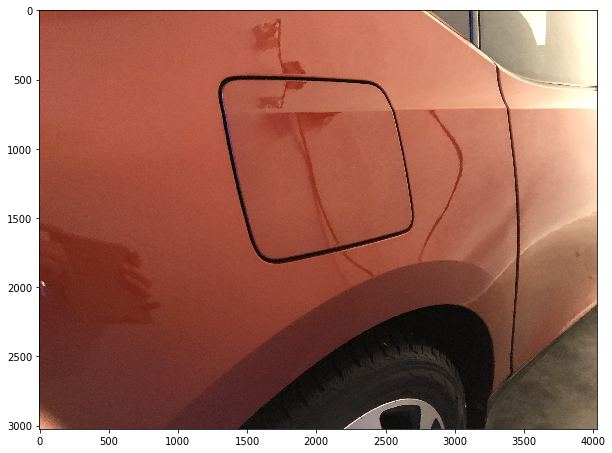

Height:		3024 pixels
Width:		4032 pixels
Channels:	3
pixel at (0,0) [B,G,R]:	[36,49,133]
data-type: uint8 


In [6]:
# Import test image

img = cv2.imread(PATH + 'images/orange i3/lid.png')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show(image)

print("Height:\t\t%i pixels\nWidth:\t\t%i pixels\nChannels:\t%i" % img.shape)
print("pixel at (0,0) [B,G,R]:\t[%i,%i,%i]" % tuple(img[0,0,:]))
print("data-type: %s " % img.dtype)

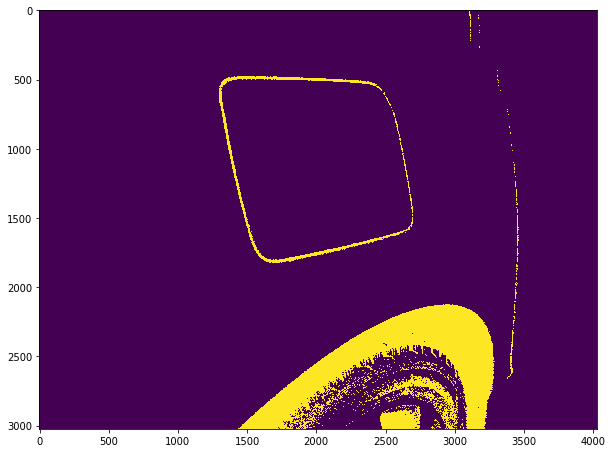

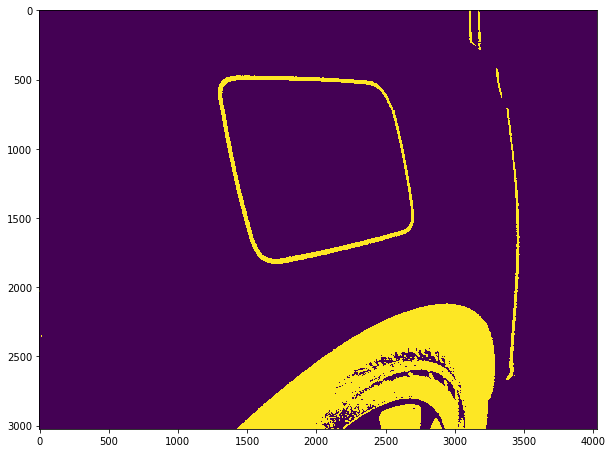

In [7]:
# Convert to binary 

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, binary = cv2.threshold(gray,30,255,cv2.THRESH_BINARY_INV)
show(binary)


# Filter binary

kernel = np.ones((5,5),np.uint8)

#erosion = cv2.erode(binary,kernel,iterations = 1)
#show(erosion)

dilation = cv2.dilate(binary, kernel, iterations = 2)
show(dilation)

#opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)
#show(opening)


[[  42.   56.]
 [  72.   81.]
 [  14.   23.]
 [  95.  101.]]
[[  14.   23.]
 [  42.   56.]
 [  72.   81.]
 [  95.  101.]]


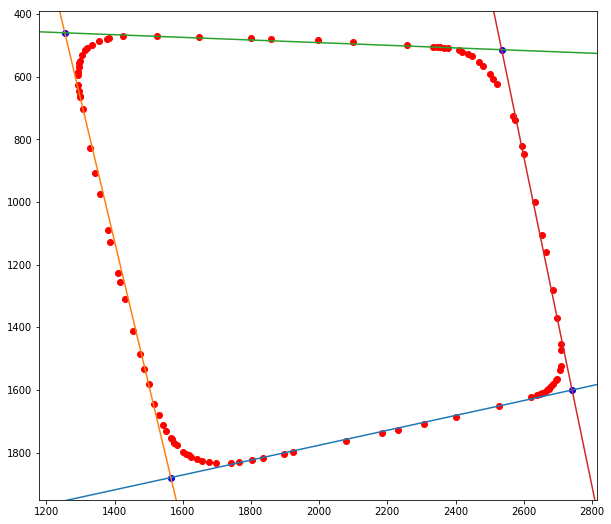

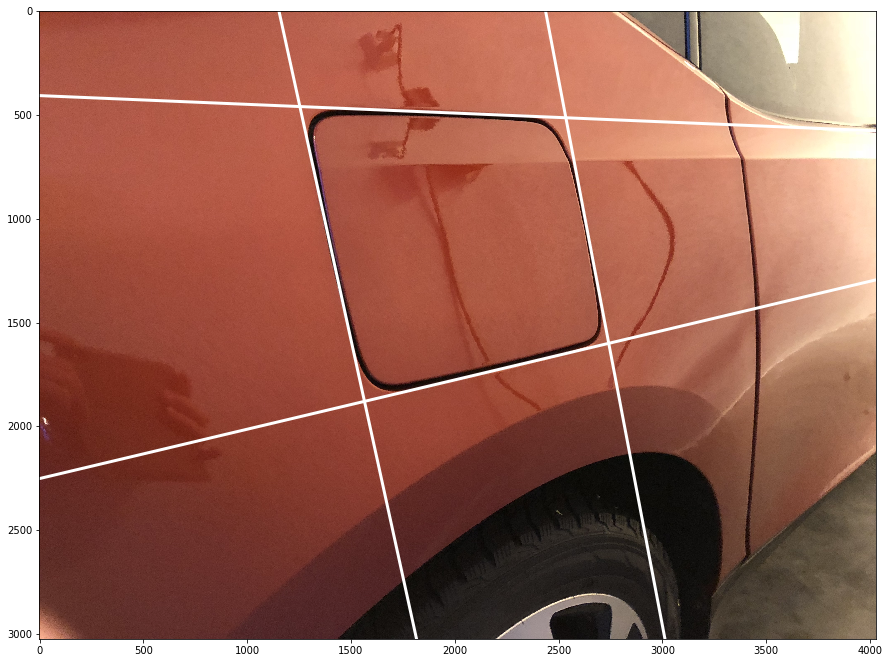

In [22]:
# Fit four corners

img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour = pr.i3PortContour(contours)

# apply convex hull to simplify contour and flatten 
points = pr.flattenToCoordianteArray(cv2.convexHull(contour))

angles = pr.anglesBetweenPoints(points)

straight = np.array([1 if a > 178.5 else 0 for a in angles])

straightFiltered = pr.removeLoneEntriesFromBinary(straight)

linePoints = pr.keepFourLongest(straightFiltered, points)

lines = [pr.lineFromPoints(p[0], p[1]) for p in linePoints]

vertices = np.array([pr.intersection(lines[i], lines[(i+1)%len(lines)]) for i in range(len(lines))])



# Plot result
plt.figure(figsize=(10,9))
plt.gca().invert_yaxis()

plt.plot(points[:,0], points[:,1], 'ro')
plt.plot(vertices[:,0], vertices[:,1], 'bo')

plotLines(lines)
plt.savefig(PATH + "recognizedPort1.png")


plt.figure(figsize=(15,20))

im = plt.imread(PATH + 'images/orange i3/lid.png')
implot = plt.imshow(im)

#plt.plot(vertices[:,0], vertices[:,1], 'bo')
plotLinesWhite(lines)
plt.savefig(PATH + "recognizedPort2.png")
plt.show()


In [7]:
# Plot lines on top of image

#plt.figure()
#show(image)

#plt.plot(corners[:,0], -corners[:,1], 'bo')

$$y(x) = y_1(0) + \frac{dy_1}{dx}x = y_2(0) + \frac{dy_2}{dx}x$$

$$ x = \frac{y_1(0)-y_2(0)}{\frac{dy_2}{dx}-\frac{dy_1}{dx}} $$

## Generalization

In [8]:
angleLimit = 175 #178.5 # any angle larger than this is considered a straight line
blackLimit = 40 #30 # any grayscale lighter than this value is considered white

def vertexPointsFromImage(img):
    
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary = cv2.threshold(gray, blackLimit, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(binary, kernel, iterations = 2)
    show(dilation)
    
    img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour = pr.i3PortContour(contours)
    points = pr.flattenToCoordianteArray(cv2.convexHull(contour))

    plt.plot(points[:,0], -points[:,1], 'ro')
    
    angles = pr.anglesBetweenPoints(points)
    straight = np.array([1 if a > angleLimit else 0 for a in angles])
    straightFiltered = pr.removeLoneEntriesFromBinary(straight)

    linePoints = pr.keepFourLongest(straightFiltered, points)
    lines = [pr.lineFromPoints(p[0], p[1]) for p in linePoints]
    plotLines(lines)
    
    return np.array([pr.intersection(lines[i], lines[(i+1)%len(lines)]) for i in range(len(lines))])

number: 3


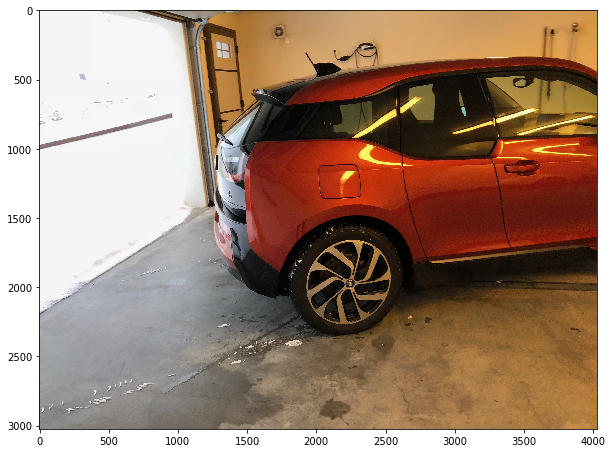

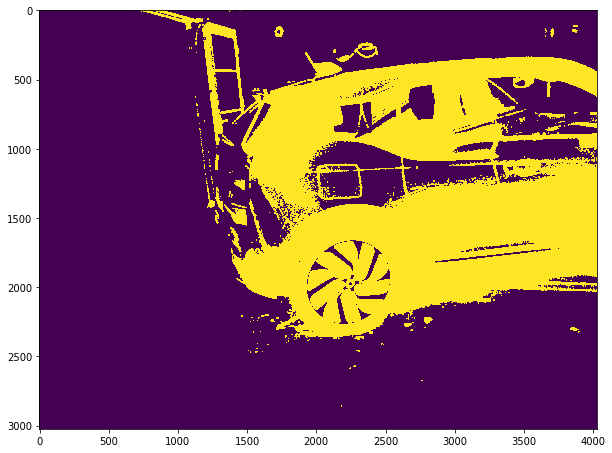

Not enough straight lines
error
number: 4


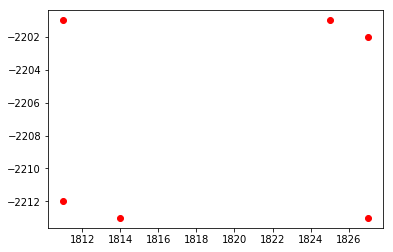

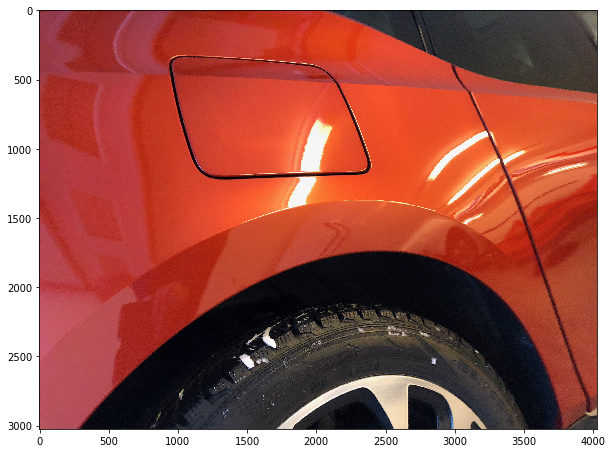

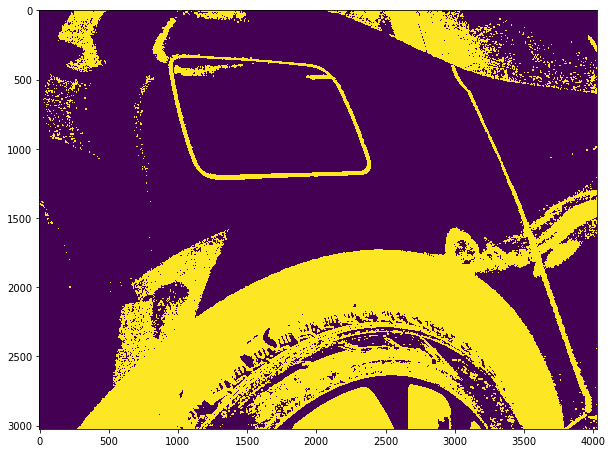

[[ 50.  59.]
 [ 11.  16.]
 [ 29.  41.]
 [ 64.  79.]]
[[ 11.  16.]
 [ 29.  41.]
 [ 50.  59.]
 [ 64.  79.]]
number: 7


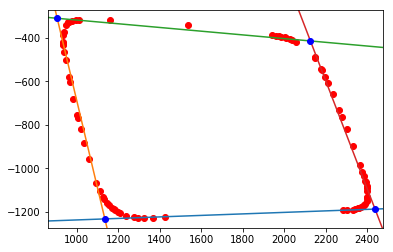

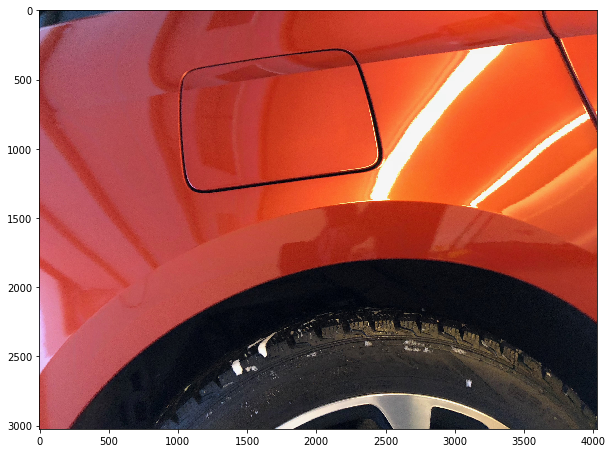

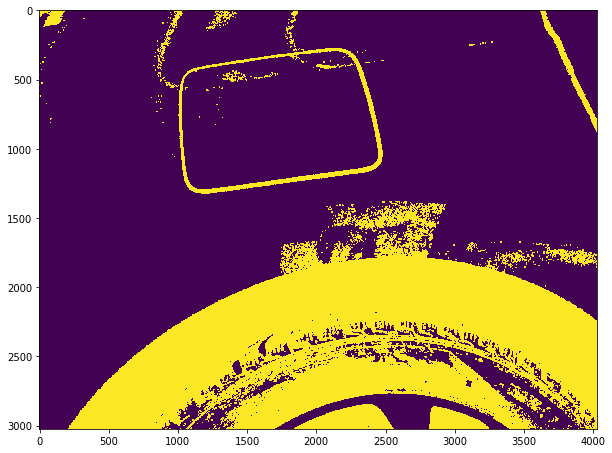

lengthFault!
error
number: 13


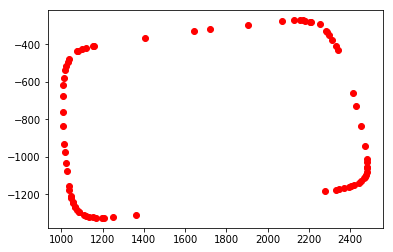

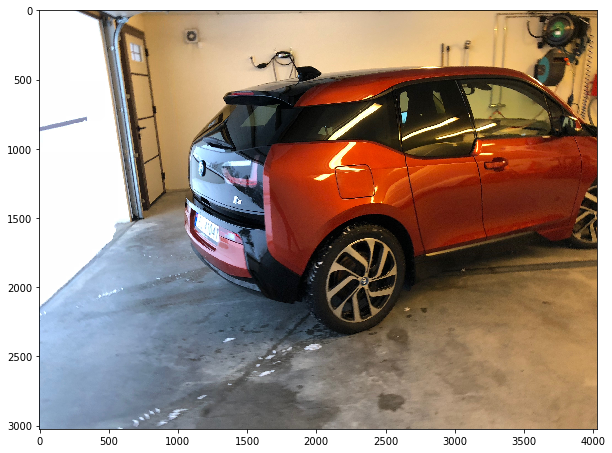

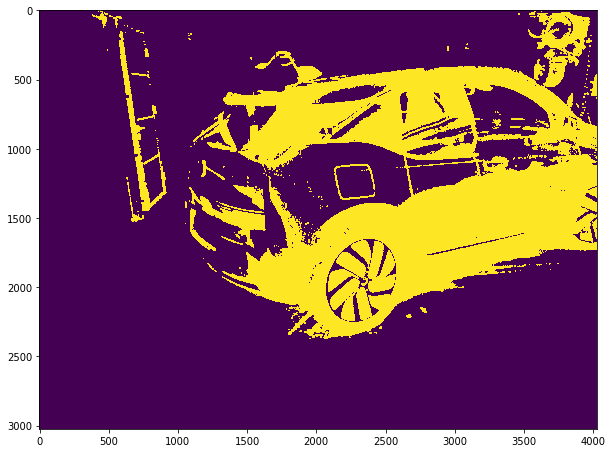

Not enough straight lines
error
number: 15


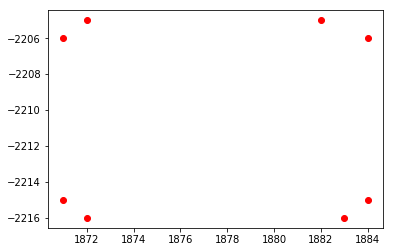

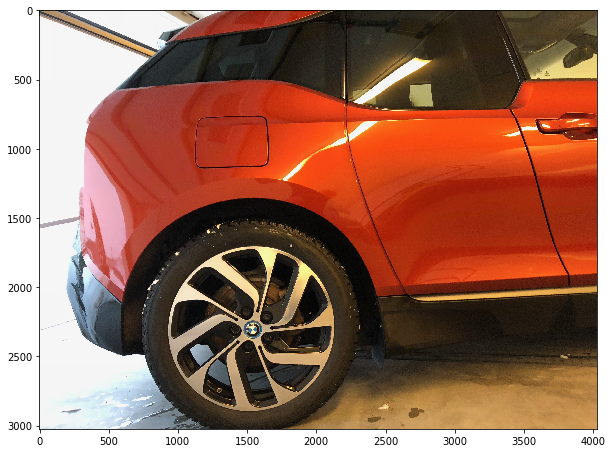

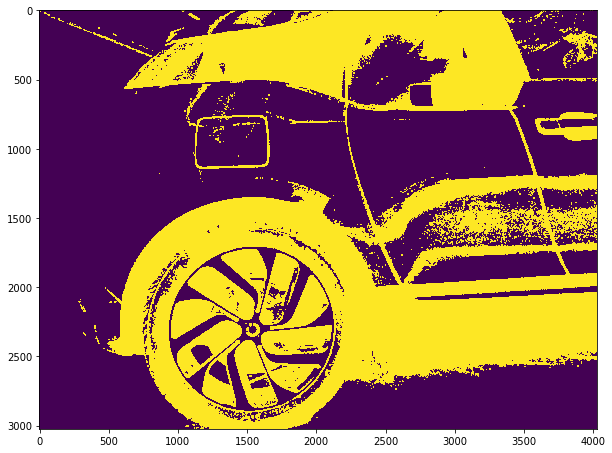

[[ 11.  17.]
 [ 36.  45.]
 [ 49.   3.]
 [ 22.  32.]]
[[ 11.  17.]
 [ 22.  32.]
 [ 36.  45.]
 [ 49.   3.]]
number: 16


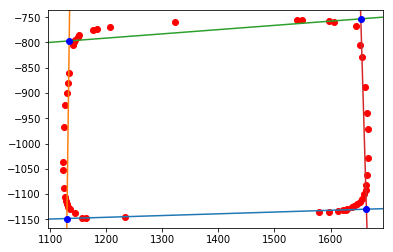

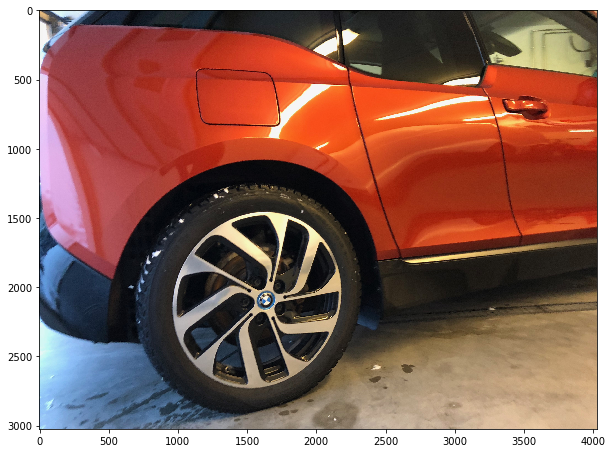

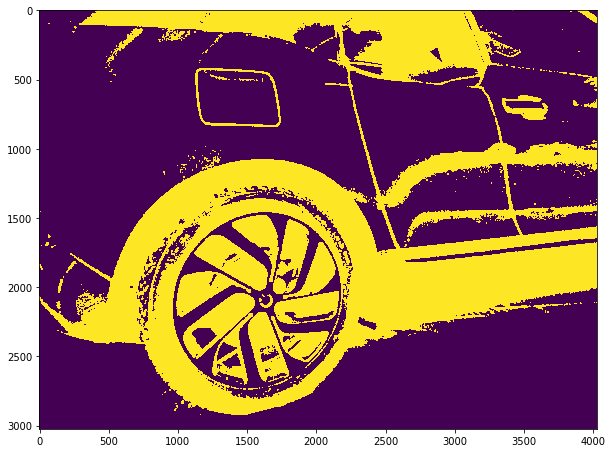

[[  9.  17.]
 [ 41.  53.]
 [ 24.  31.]
 [ 60.   0.]]
[[  9.  17.]
 [ 24.  31.]
 [ 41.  53.]
 [ 60.   0.]]
number: 21


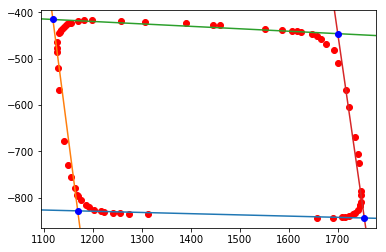

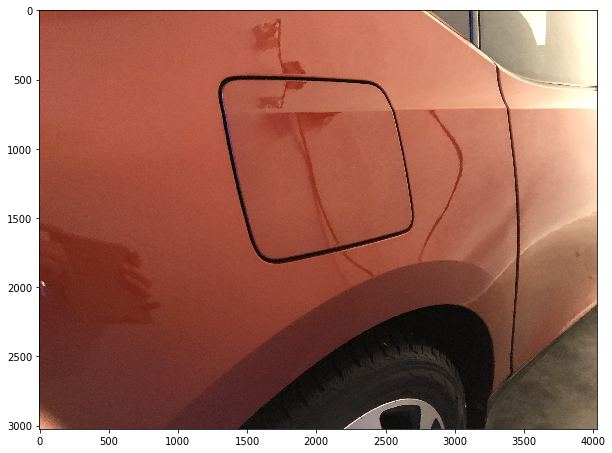

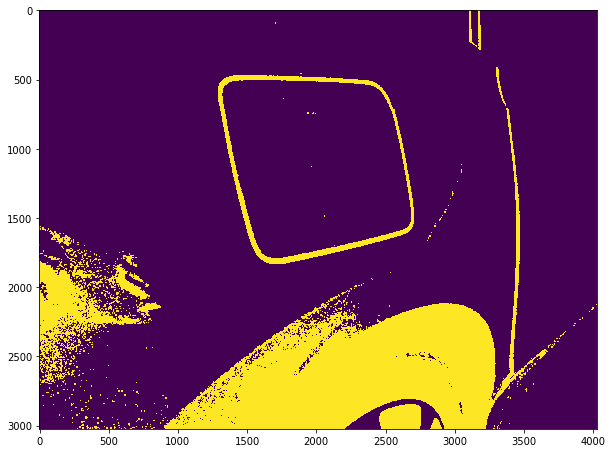

[[ 39.  63.]
 [ 90.   2.]
 [  5.  25.]
 [ 73.  83.]]
[[  5.  25.]
 [ 39.  63.]
 [ 73.  83.]
 [ 90.   2.]]
number: 22


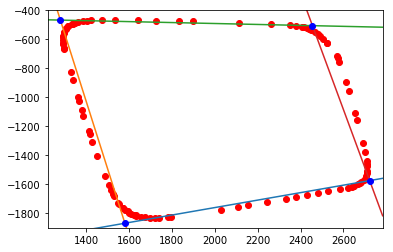

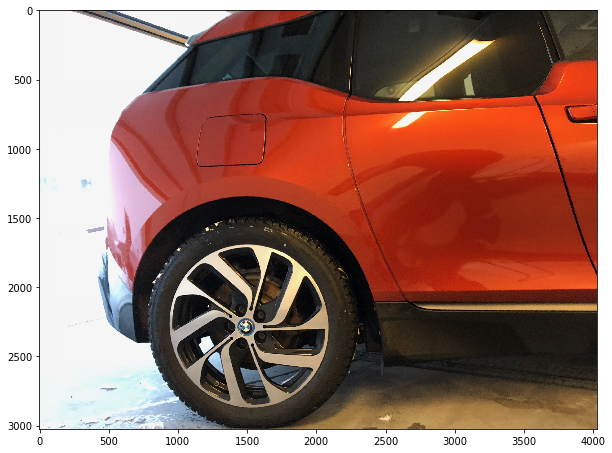

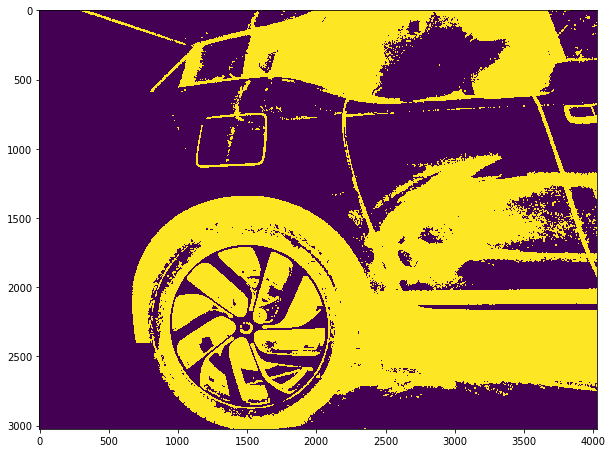

Not enough straight lines
error
number: 23


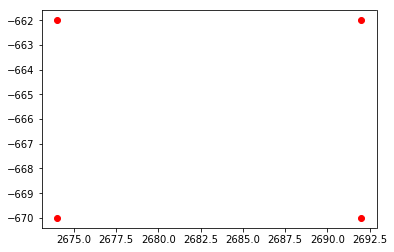

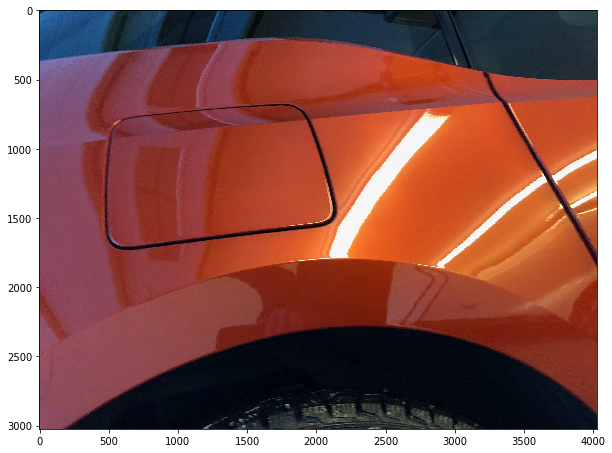

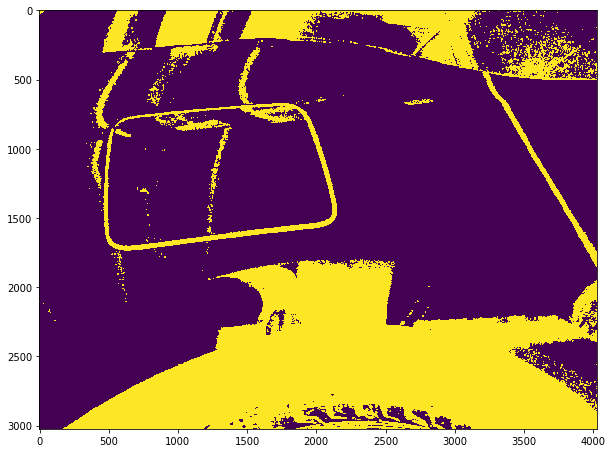

Not enough straight lines
error
number: 26


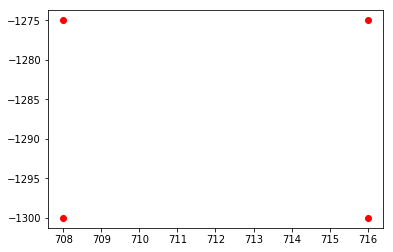

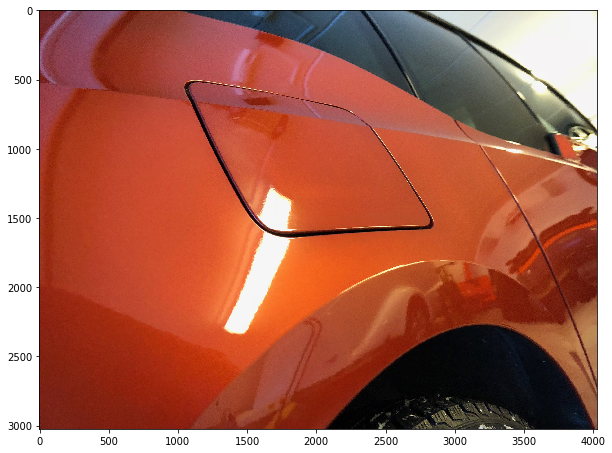

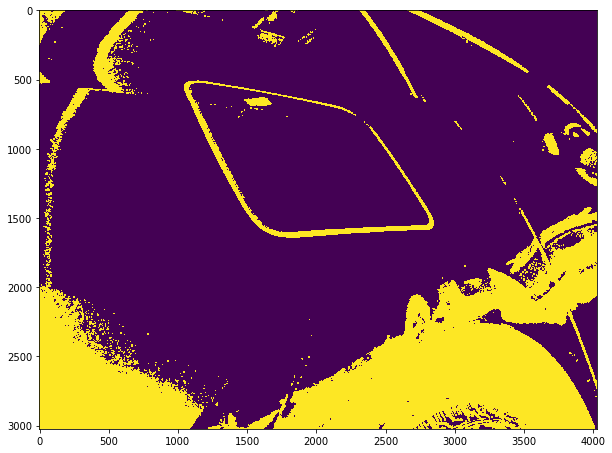

Not enough straight lines
error
number: 27


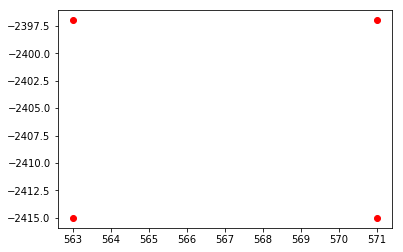

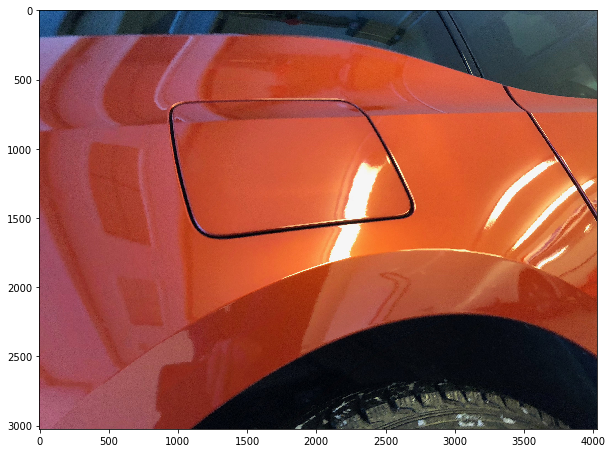

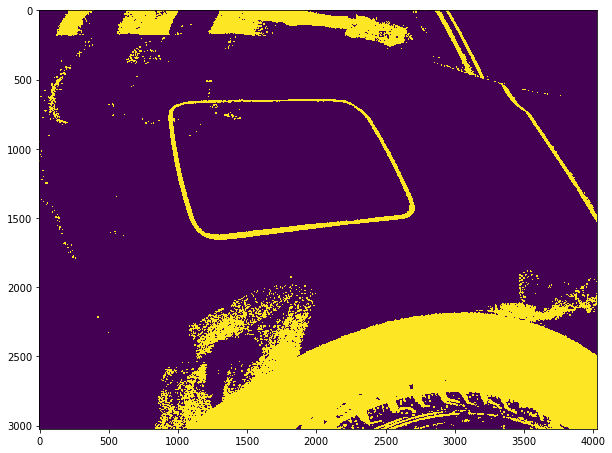

[[  3.  14.]
 [ 46.  56.]
 [ 24.  37.]
 [ 63.  75.]]
[[  3.  14.]
 [ 24.  37.]
 [ 46.  56.]
 [ 63.  75.]]
number: 29


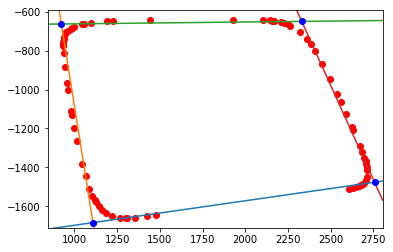

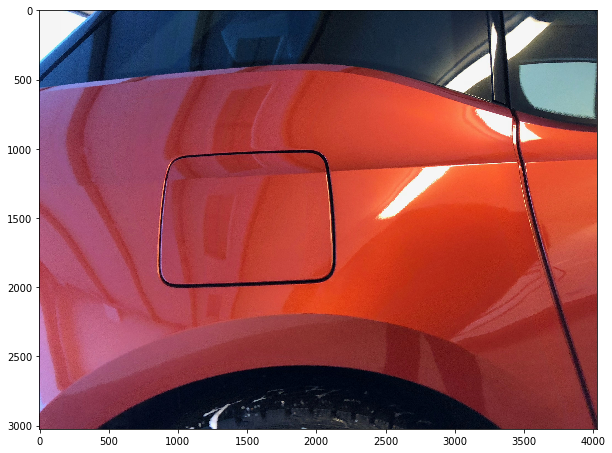

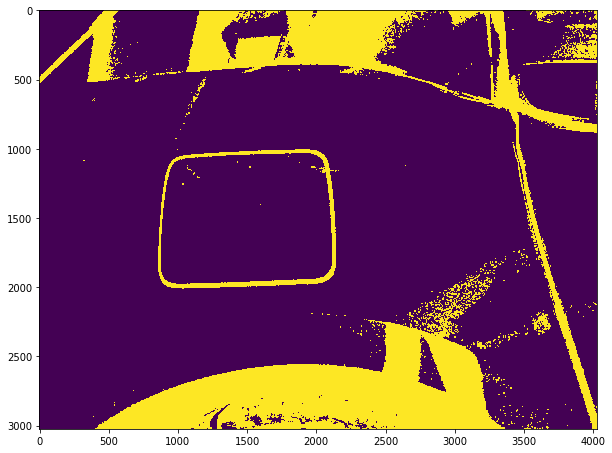

[[ 10.  15.]
 [ 56.  68.]
 [ 23.  44.]
 [ 74.   1.]]
[[ 10.  15.]
 [ 23.  44.]
 [ 56.  68.]
 [ 74.   1.]]
number: 30


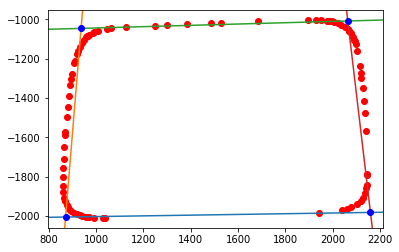

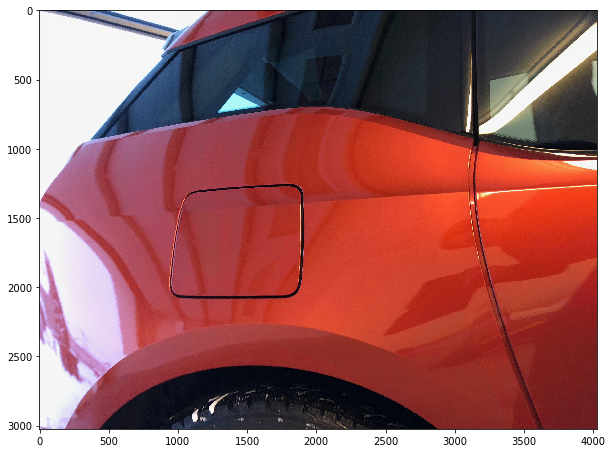

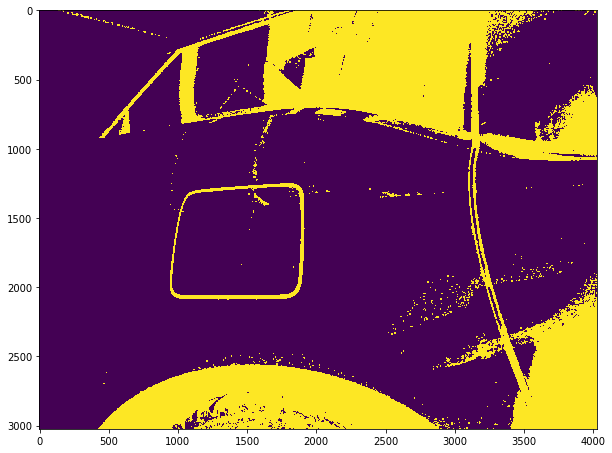

[[ 24.  33.]
 [ 92.  16.]
 [ 44.  64.]
 [ 72.  81.]]
[[ 24.  33.]
 [ 44.  64.]
 [ 72.  81.]
 [ 92.  16.]]
number: 32


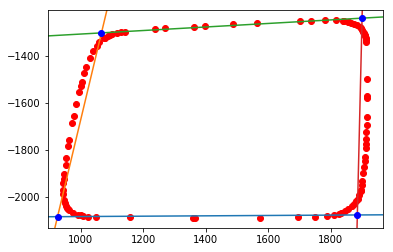

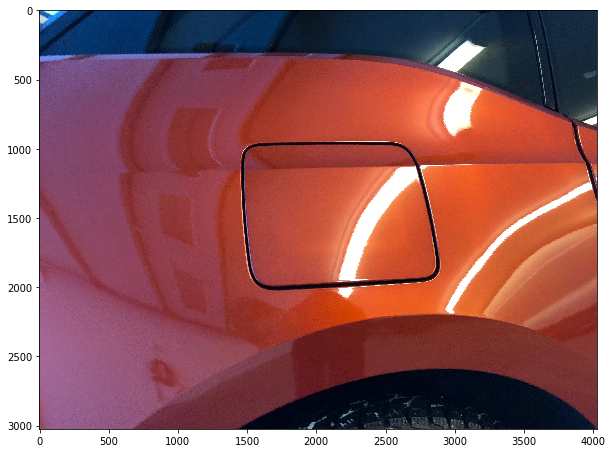

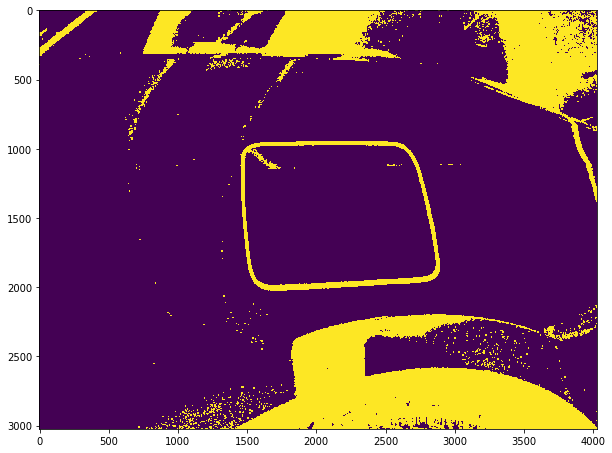

lengthFault!
[[ 10.  31.]
 [ 62.  77.]
 [ 37.  56.]
 [ 84.   2.]]
[[ 10.  31.]
 [ 37.  56.]
 [ 62.  77.]
 [ 84.   2.]]
number: 33


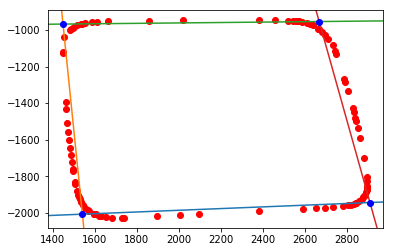

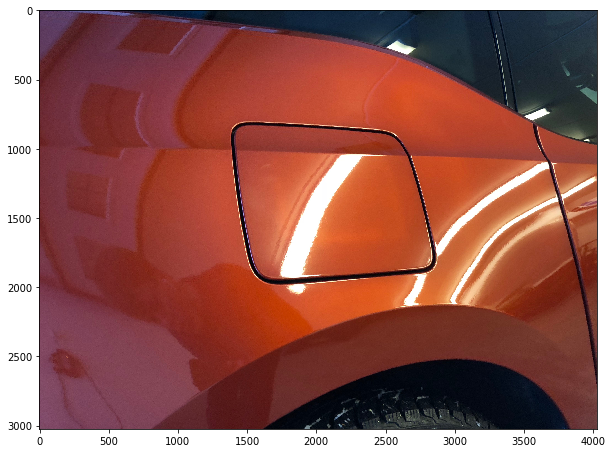

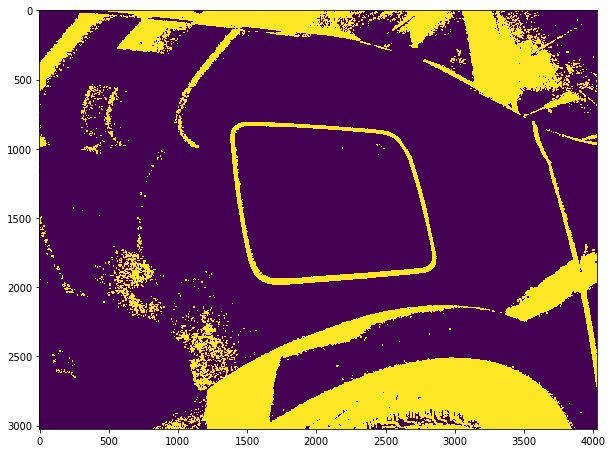

[[ 13.  30.]
 [ 73.  84.]
 [ 38.  59.]
 [ 93.   5.]]
[[ 13.  30.]
 [ 38.  59.]
 [ 73.  84.]
 [ 93.   5.]]


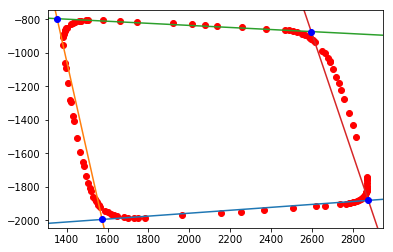

In [9]:
# Test on many images
goodImageIndecies = np.array([4, 5, 8, 14, 16, 17, 22, 23, 24, 27, 28, 30, 31, 33, 34])-1

# import all image files

path_orange_i3 = PATH + 'images/orange i3/'
orange_i3_filenames = [f for f in listdir(path_orange_i3) if isfile(join(path_orange_i3, f))]

for i in goodImageIndecies:
    print('number: ' + str(i))

    name = orange_i3_filenames[i]   
    
    img = cv2.imread(path_orange_i3 + name)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    show(image)
    
    try:
        plt.figure()
        vertices = vertexPointsFromImage(image)
        plt.plot(vertices[:,0], -vertices[:,1], 'bo')
    except:
        print('error')

# Charge Port Recognizer

## Generalization